# Machine Learning Engineer Nanodegree
## Capstone Project - Who Wrote This? 
... or how to identify the author of anonymous articles using natural languange processing.

Stefan Dittforth  
February 27th, 2018

---
## Table of contents

1. [Project Overview](#Project Overview)
2. [Data Acquisition](#Data Acquisition)
3. [Exploring the Data Set](#Exploring the Data Set)
4. [Cleaning the Dataset](#Cleaning the Dataset)
5. [Balancing the Data Set](#Balancing the Data Set)
6. [Models](#Models)  
    6.1. [Model 1: The Baseline Model - Just Guess the Author](#Model 1 The Baseline Model)  
    6.2. [Model 2: Basic Article Metrics](#Model 2 Basic Article Metrics)  
    6.3. [Model 3: Bag-of-Words - Word Count](#Model 3 Bag-of-Words - Word Count)  
    6.4. [Model 4: Bag-of-Words - TFIDF](#Model 4 Bag-of-Words - TFIDF)  
    6.5. [Model 5: Bag-of-Words - Reduced Vocabulary](#Model 5 Bag-of-Words - Reduced Vocabulary)  
    6.6. [Model 6: Bag-of-Words - Bigrams](#Model 6 Bag-of-Words - Bigrams)  
    6.7. [Model 7: Bag-of-Words - Reduced Bigrams](#Model 7 Bag-of-Words - Reduced Bigrams)  
    6.8. [Model 8: Learn Word Embeddings & CNN](#Model 8 Learn Word Embeddings & CNN)  
    6.9. [Model 9: GloVe Word Embeddings & CNN](#Model 9 GloVe Word Embeddings & CNN)  
7. [Conclusion](#Conclusion)
8. [Let's have some fun: the WhoWroteThis app](#WhoWroteThis app)
9. [Sources](#Sources)

----------------
## Project Overview <a name="Project Overview"></a>

When writing, authors leave distinctive marks in their stories influenced by the style of their writing. Well know writers are famous for their techniques with which they express ideas and manipulate language. Erika Rasso published a well written introduction to [Famous Authors and Their Writing Styles](https://www.craftyourcontent.com/famous-authors-writing-styles/). We learn, for example, that Ernest Hemingway "pioneered concise, objective prose in fiction—which had, up until then, primarily been used in journalism.". Another author discussed in Rasso's article is Franz Kafka. His stories present "surrealist, nightmarish writing in contemporary settings" which invoke feelings of confusion and helplessness. Agatha Christie's style was influenced by "mentions of war". Furthermore, "she utilized a variety of poisons to carry out the murders in her stories". And being interested in archarology "resulted in ancient artifacts and archaeologists being heavily featured in her novels". A last author worthwhile to highlight here is Zora Neale Hurston. Her style is quite unique: "She wrote in colloquial Southern dialects that mimicked the language she grew up hearing.".

Our intuition and experience as readers tells us that the style of writing is like a "finger print" that differentiates authors. If we come across a text with no information about the author or a text written under a preudonym, would we be able to tell the author based of the style of writing? An interesting article about ["Who’s At The Keyboard? Authorship Attribution in Digital Evidence Investigations"](www.utica.edu/academic/institutes/ecii/publications/articles/B49F9C4A-0362-765C-6A235CB8ABDFACFF.pdf) has been published by Carole E. Chaski. The article discusses the question to what extend text can be attributed to an author as part of crime investigations.

In this project we will explore to what extend machine learning techniques can learn the style of writing for a set of authors. A learned system would then be given a text not seen before and tries to predict who the author is.

This Jupyter Notebook has been structured in the sequential order in which the problem has been approached. The next few sections describe the data set that has been acquired and the data cleaning activities applied. This is then followed by the main section that discusses various machine learning models. The models utilize various natural language processing (NLP) and classification algorithms. The models represent different approaches to capture the "uniqueness" of writing of the different authors. The key metric against which we measure each model is the accuracy in correctly predicting the authors for a set of articles that have not been seen before (the test data set).

Lastly, we will have some fun and use the best performing model to build a small WhoWroteThis application. The user can copy and paste any text into a text input field and ask the system to guess who the author is.

#### A few notes on running this Notebook:

The total run time for this notebook is 7.3 hours on a laptop with Intel i5-5300 CPU, 2.3GHz and 8GB RAM. The notebook requires a number of libraries. All required libraries are loaded in the first code cell. Make sure this completes without any error.

----------------
## Data Acquisition <a name="Data Acquisition"></a>

In order to allow the system to learn the writing characteristics of different authors we require a dataset that provides a large number of articles for individual authors. There are rich datasets for NLP research available in the public domain. A list, as an example, can be found [here](https://github.com/niderhoff/nlp-datasets). However, as part of this project we will build our own dataset. We will develop a web scraper that will collect articles from the publishing platform Medium. The articles on Medium seem to be reasonably long (at least several hundred words). There are enough authors that have published several hundreds articles. With this, it appears feasible to acquire a large enough data set to learn patterns in the writing characteristics to distinguish between individual authors.

This approach has been chosen as an opportunity to develop practical experience not only in machine learning but also around data acquisition. In data science and machine learning the acquisition and preparation of high quality data is often the bigger challenge than the actual development of the machine learning system itself. In "[Datasets Over Algorithms](https://www.edge.org/response-detail/26587)" author Alexander Wissner-Gross notes that 

>*"the average elapsed time between key [machine learning] algorithm proposals and corresponding advances was about eighteen years, whereas the average elapsed time between key dataset availabilities and corresponding advances was less than three years, or about six times faster, suggesting that datasets might have been limiting factors in the advances."*.

Conveniently the website [Top Authors](https://topauthors.xyz/) has published a list of 300+ top Medium authors. The project folder contains the short script `get_list_of_Medium_authors.py` that has been used to extract the Medium URL for each author. The initial list of 300+ authors has been reduced to 25. The criteria for this reduction was the number of published articles. For the 25 authors there are at least 300 articles available. The Medium URLs for these authors can be found in file `Medium_authors_25.txt`.

<img src="notebook/Top Authors.jpg" alt="Drawing" style="width: 400px;"/>
<center>*getting a list of Medium authors*</center>

The actual collection of the articles is done with the script `pull_Medium_articles.py`. The script performs two steps. First, it builds a list of all article URLs and for each article saves author URL and article URL in JSON format in the file `Medium_article_urls.json`. Below is an example how the entries for three articles look like.

```javascript
{"author_URL": "https://medium.com/@tedr/latest\n",
 "article_URL": "https://medium.com/season-of-the-witch/etiquette-and-the-cancer-patient-630a50047448?source=user_profile---------1----------------"}
{"author_URL": "https://medium.com/@esterbloom/latest\n",
 "article_URL": "https://medium.com/the-billfold/failing-at-shoplifting-life-with-kesha-bc2600b1f440?source=user_profile---------789----------------"}
{"author_URL": "https://medium.com/@gassee/latest",
 "article_URL": "https://mondaynote.com/the-ny-times-un-free-at-last-df2eddba360b?source=user_profile---------281----------------"}
```

The second part performs the actual download of the articles. The script reads the article URL saved in `Medium_article_urls.json`, navigates to the website and reads the text information from the html code. Each article is saved in text format in its own file. For each author a folder is generated that contains the articles for that author. Initially it was intended to store all articles in JSON format in one file. This turned out to be very cumbersome when troubleshooting the `pull_Medium_articles.py` script. Having a folder structure that allows to do quick visual inspections over the list of files in a file manager proved very helpful. In addition, the smaller article files made it easier to spot check the downloaded text information in a text editor.

<table><tr><td><img src="notebook/article 1.PNG" style="width: 300px"></td>
           <td><img src="notebook/article 2.PNG" style="width: 300px"></td>
           <td><img src="notebook/article 3.PNG" style="width: 300px"></td></tr></table>
<center>*It's not good working with text. Got stuck reading instead of getting on the with project.*</center>

During research for this project several Python libraries for interacting with websites have been explored: [mechanize](https://pypi.python.org/pypi/mechanize/0.3.6), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#), [scrapy](https://scrapy.org/) and the [Selenium WebDriver](https://www.seleniumhq.org/projects/webdriver/). Eventually the decision was made to use the Selenium WebDriver. The key reason for this was: the Medium website uses a two step login process. The users provides its email address and then receives a one time login link via this email. That made it difficult to automate the login via script and ruled out all the libraries that don't allow user interaction with the website.

Once an article website is loaded, the required information can be pulled from the text attribute of specific html elements. The code snipped below shows the commands used to get the author name and the article text.

```python
author = self.browser.find_element_by_xpath('//a[@rel="author cc:attributionUrl"]').text
body = self.browser.find_element_by_xpath('//div[@class="postArticle-content js-postField js-notesSource js-trackedPost"]').text
```

As shown in the code snippet above the right elements are addressed by their respective xpath. Finding these xpaths required a bit of trail and error. A valuable tool for this is the FireFox Inspector. It allows to inspect the code and structure of a website and to find the right path to the right html element.

![Top Authors](notebook\Firefox Inspector.jpg)
<center>*finding the right xpath with Firefox Inspector*</center>

After the `pull_Medium_articles.py` script completed, the folder `Medium_articles` containing all article files has been compressed into a ZIP archive to preserve storage. With [`zipfile`](https://docs.python.org/3/library/zipfile.html) Python provides a library to work with ZIP archives. Going forward in this Notebook we will make use of this library to work with the files directly within the ZIP archive without the need to extract the archive.

Developing a web scraper script poses its own challenges. The initial idea is pretty straightforward: here is a list of URLs, go to each website, download the text part and save it in a file. As always, the pitfalls are discovered during implementation. Some time had to be invested to understand the structure of the Medium article websites and figure out the best way to find the right html elements that contain the required information. The Selenium WebDriver is not the most effective tool when it comes to scraping several thousand websites. The time to render each and every website adds up. An attempt has been made by parallelising the article download with multi-threading and spawning of several instances of the Firefox browser. This failed. It turned out that the fast sequence of websites caused Firefox to slowly consume all available memory and eventually Firefox stopped fetching new websites. In a parallelised version of the script the problem was only exaggerated. Finally, a pragamatic approach was taken and the script has been amended with the capability to continue the work where it has left off from a previous run. Over the course of several days the script has been restarted several times and eventually saved all articles.

In defense for Selenium, it needs to be noted that Selenium first and foremost is a tool to automate testing of websites and not a tool for scaping several thousand websites. The primary goal behind the `pull_Medium_articles.py` script was to get the data for this capstone project and not to develop a sophisticated web scraper. In this respect Selenium did the job. Despite the challenges, developing the web scraper script has been a worthwhile learing experience. It provided an opportunity to develop practical experience around data acquisition.

In the next section we will explore the data set. We will also check what data preparation or cleaning activities might be required before we can apply learning algorithms to the data set.

----------------
## Exploring the Data Set <a name="Exploring the Data Set"></a>

All articles have been downloaded in individual text files and into folders for each author. This folder and file structure has been archived into `Medium_articles.zip`. Let's go through the files and get an overview about the data set. 

In [1]:
# We use this code block to load all the libraries we will need
# throughout the Notebook. Keeping all library calls in one place at
# beginning allows to run other code cells more independently and gives
# immideate feedback about missing libraries

import wget
import zipfile
import json
import pandas as pd
import re
import random
import string
import pprint
import pickle
import hashlib
import time
import itertools
import os.path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np
from numpy import asarray
from numpy import zeros
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

C:\Users\H155936\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
Notebook_start_time = time.time()

In [3]:
def get_next_article_from_zip_file(file_name):
    """
    A generator function that reads the files in a zip archive one by one.
    """
    zf = zipfile.ZipFile(file_name, 'r')
    names = zf.namelist()
    for name in names:
        if name.endswith('.json'):
            data = zf.read(name)
            yield data
    zf.close()
    return

# read all articles into a pandas data frame
articles = pd.DataFrame(columns=['url', 'author', 'headline', 'body'])
for article_file in get_next_article_from_zip_file('Medium_articles.zip'):
    article = json.loads(article_file)
    articles = articles.append(json.loads(article_file), ignore_index=True)

In [4]:
# show a list of authors and the number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Nicole Dieker,1948
Fabricio Teixeira,1733
Ester Bloom,1328
Ethan Siegel,1323
Yann Girard,1042
Pascal Finette,1020
Jon Westenberg 🌈,932
Chris Messina,872
Mark Suster,825


Total number of articles: 18,564


---
## Cleaning the Dataset <a name="Cleaning the Dataset"></a>

The articles were downloaded by extracting the 'text' attribute from html elements that contain the body text of the article. Many articles contain images, URLs to other pages, etc. We are interested in to see if the text extracts still contain html fragments we might need to clean out. We do a check by listing the articles that contain the '<' and '>' characters. Those two characters enclose HTML tags. 

In [5]:
regex = r'<.*>' # find any HTML tag enclosing brackets
counter = 0
for index, article in articles.iterrows():
    matches = re.finditer(regex, article['body'], re.DOTALL)
    for matchNum, match in enumerate(matches):
        counter = counter + 1
        print('Match number: {}'.format(counter))
        print('Match in article index: {}'.format(index))
        print(article['url'])
        # show the first and last 20 characters of the text found
        print(match.group()[:20] + ' ... ' + match.group()[len(match.group())-20:])

Match number: 1
Match in article index: 239
https://medium.com/@bfeld/people-are-the-price-of-admission-7782d2c55bba?source=user_profile---------85----------------
<riff>
We have a set ...  not for us.
</riff>
Match number: 2
Match in article index: 258
https://medium.com/@bfeld/sanebox-make-email-great-again-fc1e52c75340?source=user_profile---------323----------------
<downarrow><enter> ... r>
Match number: 3
Match in article index: 338
https://hackernoon.com/when-brad-met-manu-cb62d561c6e0?source=user_profile---------57----------------
<manu@k9ventures.com ... manu@k9ventures.com>
Match number: 4
Match in article index: 423
https://medium.com/chris-messina/apple-tablet-concept-the-ipad-touch-7a04225887f7?source=user_profile---------201----------------
<wild conjecture>: t ... l.</wild conjecture>
Match number: 5
Match in article index: 600
https://medium.com/chris-messina/flickr-built-my-hotrod-e3be47a903d3?source=user_profile---------1085----------------
<<sigh>> ... <<sigh>>
Match 

There are only 156 occurrences for the '<' and '>' characters in over 18,500 articles. Doing some spot checks it appears that the tag brackets are genuine parts of the article text (for example the text is about HTML coding). We will leave them in for now. No need to clean them out.

Let's have a look at some articles.

In [6]:
print('A few example articles:')
for _ in range(1,4):
    i = random.randrange(len(articles))
    print('----------------------')
    print('Index: {}'.format(i))
    print('URL: {}'.format(articles.iloc[i]['url']))
    print('Author: {}'.format(articles.iloc[i]['author']))
    print('Headline: {}'.format(articles.iloc[i]['headline']))
    print('Body: {}'.format(articles.iloc[i]['body']))

A few example articles:
----------------------
Index: 1690
URL: https://medium.com/the-billfold/how-should-a-rich-person-be-29308c289be2?source=user_profile---------613----------------
Author: Ester Bloom
Headline: How Should A (Rich) Person Be?
Body: How Should A (Rich) Person Be?
It’s always a pleasant surprise when the wealthiest of us do something impressive, yet low key, to help their fellow man — like wiring thousands of dollars to help get incarcerated protesters out on bail. “Beyoncé and Jay Z are quietly subsidizing legal fees for demonstrators arrested while protesting American police brutality.”
Complex has more details, as well as screenshots of now deleted Tweets:
The Decoded contributor also spoke openly about Jay Z’s numerous private contributions to the resistance, indirectly confronting the constant flurry of detractors who repeatedly hurl claims of hypocrisy at Jay and Beyoncé surrounding their perceived silence on the issues surrounding Ferguson, Baltimore, and prote

The code above randomly selects 3 articles. We run it a few times. At each run we spot check the text in the 'body' section. It appears that the text is clean and good to go for our next step.

Typically NLP text cleaning tasks include removing punctuation characters. For now we will keep them. In one of our first classification approaches we will use them to engineer features around number and length of sentences and paragraphs in articles.

---
## Balancing the Data Set <a name="Balancing the Data Set"></a>

As seen above in the table with the number of articles per authors the data set is skewed. The number of articles ranges from 1,948 for Nicole Dieker to 307 for Gary Vaynerchuk. To avoid that our system develops a bias towards authors with a high number of articles we will balance the data set. This will be done by keeping the number of articles for each author equal to the author with the lowest number of articles.

In [7]:
# get the smallest number for articles for one author 
num_articles_to_keep = summary.min(axis=0)['number of articles']

# only keep the smallest number of articles for each author
indices_to_keep = []
for author, num_of_articles in summary.iterrows():
    indices_to_keep = indices_to_keep + \
                      list(articles[articles.author == author]\
                      [:num_articles_to_keep].index.values)
articles = articles.iloc[indices_to_keep]

# check number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Brad Feld,307
Nicole Dieker,307
howardlindzon,307
Yann Girard,307
Todd Brison,307
Tim Boucher,307
Thaddeus Howze,307
Ted Rheingold,307
Srinivas Rao,307


Total number of articles: 7,675


---
## Models <a name="Models"></a>

### Model 1: Baseline Model - Just Guess the Author <a name="Model 1 The Baseline Model"></a>

In the course of this notebook we will try several approaches to predict the author of a given text. To assess the quality of the prediction we will need to compare against some baseline. In our case we will simply do a random guess of who the author of an article is. This should get us in the order of $\frac{1}{n}\cdot100$ percent accuracy, where $n$ represents the number of authors in the dataset.

In [8]:
# a global variable that will consolidate results from all models being tested
results = pd.DataFrame(columns=['group', 'classifier', 'result', 'time'])

In [9]:
start_time = time.time()

labels = articles[['author']]
authors = labels.author.unique()
y_predict = pd.DataFrame()
y_predict['author'] = np.random.choice((authors), len(labels))
score_test = accuracy_score(labels, y_predict)

# report random guess results
print('Just guess the author:')
print('----------------------\n')
print('number of authors in data set: {}'.format(len(authors)))
print('expected prediction accuracy around: {:.2f}%'.format(1/len(authors)*100))
print('prediction accuracy score on data set: {:.2f}%'.format(score_test*100))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 1: Baseline Model',
                          'classifier': 'random selection',
                          'result': score_test,
                          'time': total_time},
                          ignore_index=True)

Just guess the author:
----------------------

number of authors in data set: 25
expected prediction accuracy around: 4.00%
prediction accuracy score on data set: 4.14%

total run time: 0.00 min



### Model 2: Basic Article Metrics <a name="Model 2 Basic Article Metrics"></a>

Let's first come up with some simple metrics as features that might help us to predict the author of an article.  The metrics that come to mind are: the total, mean, median, min and max number of words in paragraphs, sentences and the article itself. When looking at different authors it appears that these features might be useful differentiators. Some authors have a tendency to longer articles. Others use longer sentences or shorter paragraphs.

The code below "tokenizes" the articles into paragraphs, sentences and words. In addition, it counts the number of each. The tokenized article is returned as a nested dict object. The next code cell displays an example for a tokenized article.

In [10]:
pp = pprint.PrettyPrinter(indent=2)

def tokenize_paragraphs(text):
    paragraphs = [p for p in text.split('\n')]
    paragraphs_tokenized = []
    for paragraph in paragraphs:
        sentences = tokenize_sentences(paragraph)
        paragraphs_tokenized.append(sentences)
    num_paragraphs = len(paragraphs_tokenized)
    text_tokenized = {'num_paragraphs': num_paragraphs,
                      'paragraphs': paragraphs_tokenized}
    return text_tokenized

def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)
    sentences_tokenized = []
    for sentence in sentences:
        words = tokenize_words(sentence)
        sentences_tokenized.append(words)
    num_sentences = len(sentences_tokenized)
    paragraph_tokenized = {'num_sentences': num_sentences,
                           'sentences': sentences_tokenized}
    return paragraph_tokenized

def tokenize_words(sentence):
    words_tokenized = word_tokenize(sentence)
    # remove punctuations from word list
    words_tokenized = remove_punctuation(words_tokenized)
    num_words = len(words_tokenized)
    sentence_tokenized = {'num_words': num_words,
                          'words': words_tokenized}
    return sentence_tokenized

def remove_punctuation(words_tokenized):
    return [w for w in words_tokenized 
            if not re.fullmatch('[' + string.punctuation + '’“‘”–…' ']', w)]

def get_article_metrics(body):
    body_tokenized = tokenize_paragraphs(body)
    paragraphs_sentences = []
    sentences_words = []
    for paragraph in body_tokenized['paragraphs']:
        paragraphs_sentences.append(paragraph['num_sentences'])
        for sentence in paragraph['sentences']:
            sentences_words.append(sentence['num_words'])
    paragraphs_sentences = pd.Series(paragraphs_sentences)
    sentences_words = pd.Series(sentences_words)
    metrics = {'article_num_paragraphs': body_tokenized['num_paragraphs'],
               'article_num_sentences': paragraphs_sentences.sum(),
               'article_num_words': sentences_words.sum(),
               'paragraphs_min_sentences': paragraphs_sentences.min(),
               'paragraphs_max_sentences': paragraphs_sentences.max(),
               'paragraphs_mean_sentences': paragraphs_sentences.mean(),
               'paragraphs_median_sentences': paragraphs_sentences.median(),
               'sentences_min_words': sentences_words.min(),
               'sentences_max_words': sentences_words.max(),
               'sentences_mean_words': sentences_words.mean(),
               'sentences_median_words': sentences_words.median()}
    return metrics

In [11]:
# calculate the basic metrics for each article
articles_metrics = pd.DataFrame(list(articles['body'].map(get_article_metrics)),
                                index=articles.index)
articles_metrics.insert(loc=0, column='author', value=articles['author'])
display(articles_metrics)

,author,article_num_paragraphs,article_num_sentences,article_num_words,paragraphs_max_sentences,paragraphs_mean_sentences,paragraphs_median_sentences,paragraphs_min_sentences,sentences_max_words,sentences_mean_words,sentences_median_words,sentences_min_words
0,Brad Feld,3,5,67,3,1.666667,1.0,1,31,13.400000,9.0,2
1,Brad Feld,3,4,68,2,1.333333,1.0,1,43,17.000000,10.0,5
2,Brad Feld,13,45,708,7,3.461538,3.0,1,30,15.733333,17.0,3
3,Brad Feld,5,10,90,5,2.000000,1.0,1,19,9.000000,8.0,1
4,Brad Feld,16,40,582,5,2.500000,2.0,1,48,14.550000,12.0,2
5,Brad Feld,7,23,424,7,3.285714,3.0,1,42,18.434783,18.0,3
6,Brad Feld,19,52,860,5,2.736842,3.0,1,41,16.538462,14.5,5
7,Brad Feld,6,12,223,4,2.000000,1.5,1,49,18.583333,15.5,5
8,Brad Feld,14,42,755,6,3.000000,3.0,1,50,17.976190,16.5,3
9,Brad Feld,14,32,494,7,2.285714,2.0,1,38,15.437500,13.0,4


To get some insight into the length of articles we will plot a histogram for each author that shows the distribution of article lengths.

In [12]:
def plot_article_histograms(articles_metrics):
    authors = itertools.cycle(set(articles_metrics['author']))
    num_of_authors = len(set(articles_metrics['author']))
    plots_per_axis = math.ceil(np.sqrt(num_of_authors))
    
    # set up the figure 
    fig, axes = plt.subplots(nrows=plots_per_axis, ncols=plots_per_axis)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle("Article Length Distribution", fontsize=18, y=0.93)
    
    # add the common label for x and y axis
    fig.text(0.5, 0.085, 'length of articles (number of words)', ha='center', fontsize=18)
    fig.text(0.085, 0.5, 'number of articles', va='center', rotation='vertical', fontsize=18)
    
    # histogram for each author
    n_bins = 50
    for col in range(plots_per_axis):
        for row in range(plots_per_axis):
            author = next(authors)
            y = articles_metrics[articles_metrics['author'] == author]['article_num_words']
            axes[row][col].hist(y, bins=n_bins)
            axes[row][col].set_xlim([0,3000])
            axes[row][col].set_ylim([0,150])
            axes[row][col].tick_params(labelsize=12)
            axes[row][col].set_title(author)

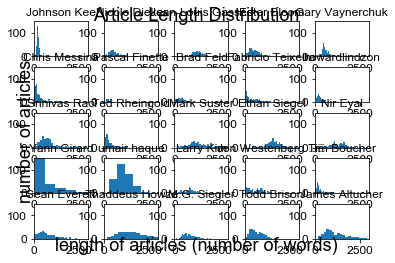

In [13]:
figure1 = plot_article_histograms(articles_metrics[['author', 'article_num_words']])
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = [16, 16]
plt.show()

And here is how a tokenized article looks like ...

In [14]:
# display an example for a tokenized article
sample_article_index = 1 # just a random pick
body_tokenized = tokenize_paragraphs(articles.loc[sample_article_index]['body'])
print('\nSample article tokenized:\n')
pp.pprint(body_tokenized)


Sample article tokenized:

{ 'num_paragraphs': 3,
  'paragraphs': [ { 'num_sentences': 1,
                    'sentences': [ { 'num_words': 11,
                                     'words': [ '11/17',
                                                'Sports',
                                                'Startups',
                                                'and',
                                                'San',
                                                'Diego',
                                                'An',
                                                'Evening',
                                                'with',
                                                'Brad',
                                                'Feld']}]},
                  { 'num_sentences': 2,
                    'sentences': [ { 'num_words': 43,
                                     'words': [ 'If',
                                                'you',
                         

Now that we have the basic metrics as features in a pandas data frame we will plot a few scatter diagrams to get a feeling for how strong they separate different authors.

In [15]:
def plot_feature_scatters(articles_list, authors, plot_features, plot_labels):
    num_features = plot_features.__len__()
    
    # set up the figure 
    fig, axes = plt.subplots(nrows=num_features, ncols=num_features)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle("Feature Relationships", fontsize=18)
    
    # set up the axes
    for ax in axes.flat:
        ax.tick_params(axis='both',
                       bottom='off', top='off', left='off', right='off',
                       labelbottom='off', labeltop='off',
                       labelleft='off', labelright='off')
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(axis='y', left='on', labelleft='on')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.tick_params(axis='y', right='on', labelright='on')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.tick_params(axis='x', top='on', labeltop='on')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.tick_params(axis='x', bottom='on', labelbottom='on')
        # set colour cycler, each author a different colour 
        ax.set_prop_cycle(cycler('color', ['blue', 'green', 'red', 'cyan',
                                           'magenta', 'yellow', 'black', 'white']))
        
    # plot the scatter plots
    for c in range(num_features):
        for r in range(num_features):
            if c == r:
                # leave diagonal plots empty and remove ticks and labels
                axes[r, c].xaxis.set_visible(False)
                axes[r, c].yaxis.set_visible(False)
            elif r > c:
                axes[r, c].axis('off')
            else:
                axes[r, c].set_prop_cycle(None) # reset colour cycler
                for author in authors:
                    x = articles_list[articles_list.author == author][plot_features[c]]
                    y = articles_list[articles_list.author == author][plot_features[r]]
                    axes[r, c].scatter(x, y, s=2, alpha=0.5, label=author)

    # place a legend below the top left plot
    axes[0, 1].legend(bbox_to_anchor=(-1.1, 1), loc=3, prop={'size': 12}, markerscale=6)

    # add axis labels in diagonal boxes
    for i, label in enumerate(plot_labels):
        axes[i,i].annotate(label, (0.5, 0.5), 
                           xycoords='axes fraction', ha='center', va='center',
                           size=12)
    
    return fig

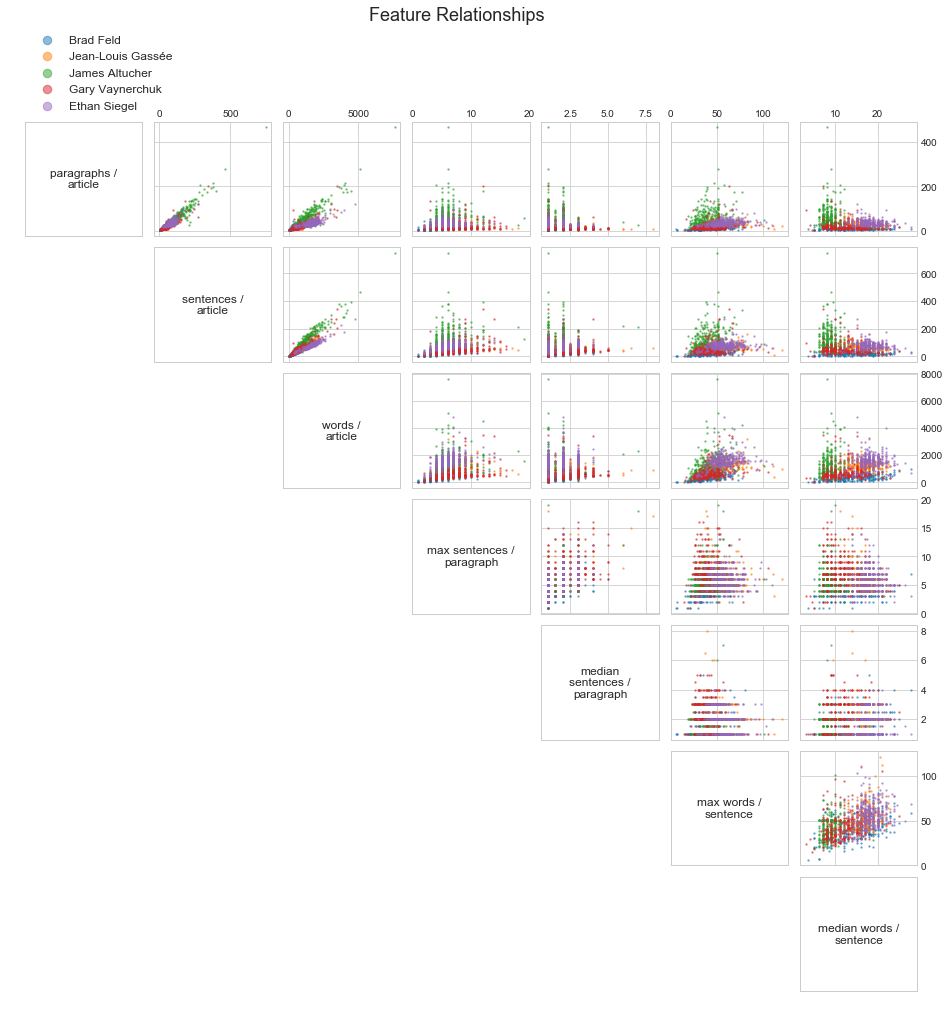

In [16]:
figure1 = plot_feature_scatters(articles_metrics,
                ['Brad Feld', 'Jean-Louis Gassée',
                 'James Altucher', 'Gary Vaynerchuk', 'Ethan Siegel'],
                ['article_num_paragraphs', 'article_num_sentences', 'article_num_words',
                 'paragraphs_max_sentences', 'paragraphs_median_sentences',
                 'sentences_max_words', 'sentences_median_words'],
                ['paragraphs /\narticle', 'sentences /\narticle', 'words /\narticle',
                 'max sentences /\nparagraph', 'median\nsentences /\nparagraph',
                 'max words /\nsentence', 'median words /\nsentence'])

#%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = [13, 13]
plt.show()

From the scatter plots above it appears that a separation to some degree would be possible. For example, the plot for "words / article" vs "max words / sentence" shows distinct clusters for individual authors. Although the clusters seem to overlap quite a bit.

We will run a few classifier models and see what prediction accuracy we can achieve on a training data set. First, we will try the decision tree algorithm.

In [17]:
# split labels into separate data frame
data = articles_metrics
labels = data[['author']]
data = data.drop('author', 1)

# shuffle training test split
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.25,
                                                    random_state=23)
start_time = time.time()

# decision tree prediction model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))

# report decision tree results
print('decision tree classifier:')
print('-------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 2: Basic Article Metrics',
                          'classifier': 'decision tree',
                          'result': score_test,
                          'time': total_time},
                          ignore_index=True)

decision tree classifier:
-------------------------

prediction accuracy score on training data set: 99.98%
prediction accuracy score on test data set: 33.56%

total run time: 0.00 min



Nearly 100% on the training data! That's awesome!

Ok.... just joking ;-)

On unseen data the accuracy is around 33% (the value will vary slightly with each run). I think that's not too bad for a model that tries to guess the author of an article only based on the number of words in articles, paragraphs and sentences. The model does not take anything of the article content into account. The 100% accuracy on the training data means the model is extremly biased. It would be interesting to see if a grid search can find a better set of parameters.

In [18]:
def grid_search(X_train, y_train):
    # setup grid search
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.25, random_state = 23)
    learning_model = tree.DecisionTreeClassifier()
    params = {'max_depth': list(range(1,30)),
              'min_samples_split': list(range(2,50))}
    scoring_fnc = make_scorer(accuracy_score, greater_is_better=True)
    grid = GridSearchCV(estimator=learning_model,
                        param_grid=params,
                        scoring=scoring_fnc,
                        cv=cv_sets,
                        verbose=2)

    # run grid search
    grid = grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    return best_clf

def get_classifier():
    '''
    Get the best classifier. Run grid search and save the best classifier to
    a pickle file. If the pickle file exists load the best classifier from file
    instead of running grid search again. This saves time in subsequent runs 
    of the Notebook.
    '''
    pickle_file = 'Model 2 Basic Article Metrics - grid search best estimator.pickle'
    if os.path.isfile(pickle_file):
        with open(pickle_file,'rb') as f:
            best_clf = pickle.loads(f.read())
    else:
        best_clf = grid_search(X_train, y_train)
        with open(pickle_file, 'wb') as f:
            s = pickle.dumps(best_clf)
            f.write(s)
    return best_clf

In [19]:
start_time = time.time()

best_clf = get_classifier()
score_test = accuracy_score(y_test, best_clf.predict(X_test))
print('GridSearch prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))
print('best parameters:')
print('    max_depth:{0}'.format(best_clf.get_params()['max_depth']))
print('    min_samples_split:{0}'.format(best_clf.get_params()['min_samples_split']))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 2: Basic Article Metrics',
                          'classifier': 'grid search decision tree',
                          'result': score_test,
                          'time': total_time},
                          ignore_index=True)

GridSearch prediction accuracy score on test data set: 36.22%
best parameters:
    max_depth:10
    min_samples_split:23

total run time: 0.00 min



The optimisation of two parameters with grid search gains us three more percentage points to 36%. A little bit better.

For comparison we will run the logistic regression algorithm and see if that yields better results. 

In [20]:
start_time = time.time()

# logistic regression prediction model
clf = linear_model.LogisticRegression()
clf = clf.fit(X_train, y_train.values.ravel())
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))

# report logistic regression results
print('\nlogistic regression classifier:')
print('-------------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 2: Basic Article Metrics',
                          'classifier': 'logistic regression',
                          'result': score_test,
                          'time': total_time},
                          ignore_index=True)


logistic regression classifier:
-------------------------------

prediction accuracy score on training data set: 34.69%
prediction accuracy score on test data set: 32.20%

total run time: 0.03 min



With 32% accuracy the result is 4% below what has been achieved with an (grid search) optimised decision tree algorithm.

### Model 3: Bag-of-Words - Word Count <a name="Model 3 Bag-of-Words - Word Count"></a>

In our next model we will use the vocabulary to build our prediction model. We will implement a the Bag-of-Words algorithm. Bag-of-Words is a very simple but often surprisingly effective algorithm. It takes all the different words in a training set and uses them as features. Each article is then transformed into a feature vector by marking the occurrence of each feature (=word). There are a few variations of Bag-of-Words. In it's basic form each vector counts the number of occurrences for each word. This is what we are going to use in this model 3. In the next section (model 4) will use the term frequency–inverse document frequency (TFIDF) approach to build the Bag-of-Words vectors.

The code cell below defines a number of functions. The approach to define functions vs. directly executed code cells has been choosen to make the code reuseable for the next model in the following section.

Besides the training, predicting and scoring functionalties the code implementes two additional capabilities: 1.) it allows trained classifiers to be saved to or loaded from disk. This saves time when the Notebook is run multiple times. The model needs to be trained only once. 2.) The model can be trained with different classifiers. During experiementation very often different classifiers (e.g. logistic regression, decision tree, SVM) are tested to evaluate which one is most suitable for a problem.

In [21]:
def train(articles_train, pickle_file, classifiers, vectorizer_type):
    """ This function is called to either load a trained model from disk
    or to start the training. A trained model is loaded automatically 
    when the file exists.
    """
    if os.path.isfile(pickle_file):
        vectorizer, trained_classifiers = load_trained_classifiers(pickle_file)
    else:
        vectorizer, trained_classifiers = train_classifiers(articles_train,
                                                            classifiers,
                                                            vectorizer_type)
        save_trained_classifiers(vectorizer, trained_classifiers, pickle_file)
    return vectorizer, trained_classifiers

def load_trained_classifiers(pickle_file):
    """ Load a trained model from disk.
    """
    with open(pickle_file,'rb') as f:
        saved_items = pickle.loads(f.read())
    trained_classifiers = saved_items['trained_classifiers']
    vectorizer = saved_items['vectorizer']
    return vectorizer, trained_classifiers

def save_trained_classifiers(vectorizer, trained_classifiers, pickle_file):
    """ Save a trained model to disk. For Bag-of-Words there are two elements
    that need to be saved: the classifiers that have been trained (e.g. logistic
    regression, SVM) and the vectorizer. The vectorizer is the object that contains
    the vocabulary that has been trained from the training data set. The vecorizer
    is required later on to transform any given text into a vector representation.
    """
    saved_items = {'trained_classifiers': trained_classifiers,
                   'vectorizer': vectorizer}
    with open(pickle_file, 'wb') as f:
        s = pickle.dumps(saved_items)
        f.write(s)

def train_classifiers(articles_train, classifiers, vectorizer_type):
    """ This function performs the training for each classifier. The desired 
    classifieres are given as a list of dictionaries. Each entry spacifies an
    'algorithm' and the 'display_text'.
    """
    vectorizer, X_train = fit_transform_vectors(articles_train, vectorizer_type)
    y_train = articles_train[['author']]
    trained_classifiers = []
    for classifier in classifiers:
        classifier_algorithm = classifier['algorithm']
        display_text = classifier['display_text']
        clf = train_classifier(X_train, y_train, classifier_algorithm)
        trained_classifiers.append({'clf': clf, 'display_text': classifier['display_text']})
    return vectorizer, trained_classifiers

def train_classifier(data, labels, classifier_algorithm):
    """ Train a single classifier.
    """
    X_train = data
    y_train = labels
    clf = classifier_algorithm
    clf = clf.fit(X_train, y_train.values.ravel())
    return clf

def fit_transform_vectors(articles, vectorizer):
    """ Build the vocabulary during training.
    """
    data = pre_process_articles(articles)
    data_vectorized = vectorizer.fit_transform(data)
    return vectorizer, data_vectorized

def transform_vectors(articles, vectorizer):
    """ Transform a list of articles into Bag-of-Words vectors. This is used
    once a mopdel has been trained to transform articles in preparation for
    prediction.
    """
    articles = pre_process_articles(articles)
    articles = vectorizer.transform(articles)
    return articles

def pre_process_articles(articles):
    # join all articles to one string in preparation for hash calculation
    data = ''.join([article['body'] for index, article in articles.iterrows()])
    # calculate MD5 hash across all articles
    m = hashlib.md5()
    m.update(data.encode('utf-8'))
    md5_digest = m.hexdigest()
    pickle_file_name = 'pre_processed_articles_' + md5_digest + '.pickle'
    # load from disk or pre-process articles and save to disk
    if os.path.isfile(pickle_file_name):
        with open(pickle_file_name,'rb') as f:
            data = pickle.loads(f.read())
    else:
        data = [pre_process_text(article['body']) for index, article in articles.iterrows()]
        with open(pickle_file_name, 'wb') as f:
            s = pickle.dumps(data)
            f.write(s)
    return data

# def pre_process_text(article): # buggy function
#     """ Some preprocessing and cleaning tasks to be applied to the raw input text
#     of an article.
#     """
#     stop_words = set(stopwords.words('english'))
#     porter = PorterStemmer()
#     # tokenize article into words
#     words = tokenize_words(article)['words']
#     # remove stop words
#     words = [word for word in words if not word in stop_words]
#     # reduce words to its base and make all words lowercase
#     words = set([porter.stem(word) for word in words]) <-- here's the bug, 
#                                                            funnily enough this unintended set() increases logistic 
#                                                            regression performance by 3%, need to investigate
#                                                            this someday
#     processed_text = ' '.join(words)
#     return processed_text

def pre_process_text(article): # fixed function
    """ Some preprocessing and cleaning tasks to be applied to the raw input text
    of an article.
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    # tokenize article into words
    words = tokenize_words(article)['words']
    # lower case
    words = [word.lower() for word in words]
    # remove stop words
    words = [word for word in words if not word in stop_words]
    # reduce words to its base and make all words lowercase
    words = [porter.stem(word) for word in words]
    # remove punctuation from word list
    re_punc = re.compile('[%s]' % re.escape(string.punctuation + '—'))
    words = [re_punc.sub('', w) for w in words]
    # return as single string, required for, e.g., count or TFDIF vectorizers
    processed_text = ' '.join(words)
    return processed_text

Next we will utilize the functions above to build our model. A model will be represented as a Python class. This design decision was driven by a view that our model should be "productized" to some degree. A user of our WhoWroteThis model will want to use a simple and straighforward interface. She should be able to pass in a list of articles in human readable text format and all the activities around text preprocessing, cleaning and vectorizing the data should be hidden.

In [22]:
class Model_Bag_of_Words:
    
    def __init__(self, pickle_file):
        """ The user of this class can specify the file name under which 
        the trained model will be saved to disk.
        
        As of now the model is fixed to autmatically train the following
        classifiers: logistic regression, decision tree and support vector
        machine (SVM).
        """
        self.pickle_file = pickle_file
        self.classifiers = [
            {'algorithm': linear_model.LogisticRegression(),
             'display_text': 'logistic regression'},
            {'algorithm': tree.DecisionTreeClassifier(),
             'display_text': 'decision tree'},
            {'algorithm': svm.SVC(probability=True),
             'display_text': 'SVM'}
        ]
        self.vectorizer = None
        self.trained_classifiers = None

    def train(self, articles_train, vectorizer_type):
        """ Train the model on the various classifiers.
        """
        self.vectorizer, self.trained_classifiers = train(articles_train,
                                                          self.pickle_file,
                                                          self.classifiers,
                                                          vectorizer_type)

    def predict(self, articles, classifier_type):
        """ For a given list of articles and the classifier 
        type (logistic regression, decision tree and SVM) predict the
        authors.
        """
        for clf in self.trained_classifiers:
            if clf['display_text'] == classifier_type:
                break
        articles = transform_vectors(articles, self.vectorizer)
        prediction = pd.DataFrame({'author': clf['clf'].classes_,
                                   'probability': clf['clf'].predict_proba(articles)[0]})
        return prediction
    
    def score(self, articles):
        """ Score prediction accuracy for a given list of articles.
        """
        labels_actual = articles[['author']]
        articles = transform_vectors(articles, self.vectorizer)
        clf_predictions = []
        for clf in self.trained_classifiers:
            labels_predicted = clf['clf'].predict(articles)
            score = accuracy_score(labels_actual, labels_predicted)
            clf_predictions.append({'classifier': clf['display_text'],
                                    'labels_predicted': labels_predicted,
                                    'score': score})
            print('{} classifier prediction accuracy score : {:.2f}%'.format(clf['display_text'], score*100))
        return clf_predictions

We run our Bag-of-Words model with word counts. Please note the strongly simplified interface by using the `Model_Bag_of_Words` class. It allows to work directly with the article texts and hides the machine learning "pipeline" (preprocessing, cleaning, vectorization, training of various classifiers).

In [23]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

model_WordCount = Model_Bag_of_Words('Model 3 Bag-of-Words - Word Count.pickle')
print('training the model\n')
model_WordCount.train(articles_train, CountVectorizer())
print('number of training articles: {:,}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {:,}'.\
      format(len(model_WordCount.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_WordCount.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_WordCount.score(articles_test)

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
for clf in clf_predictions:
    results = results.append({'group': 'Model 3: Bag-of-Words - Word Count',
                              'classifier': clf['classifier'],
                              'result': clf['score'],
                              'time': total_time},
                              ignore_index=True)

training the model

number of training articles: 5,756
size of the vocabulary = length of the feature vector: 63,021

scoring the training data:

logistic regression classifier prediction accuracy score : 100.00%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 33.10%

scoring the test data:

logistic regression classifier prediction accuracy score : 92.55%
decision tree classifier prediction accuracy score : 76.76%
SVM classifier prediction accuracy score : 29.55%

total run time: 1.66 min



Using the logistic regression classifier gets us well above 92% prediction accuracy on the test data set. That's not bad! It appears that simply counting the word frequency is a very strong differentiator between authors. It seems to confirm our intuition that a person is able to differentiate between authors by what they write about. Different topics will naturally use different vocabulary. For future research (not pursued in this project) it might be interesting to research how the classifier works for authors that write about the same or similar topics.

From the accuracy scores on training and test data we can see that the SVM classifier doesn't perform so well on this particular problem. This comes a bit as a surprise. According to the [scikit learn documentation](http://scikit-learn.org/stable/modules/svm.html) SVM is a classifier that generally is effective in high dimensional space and, more importantly, is "still effective in cases where number of dimensions is greater than the number of samples". In our case the number of 63,021 dimensions (= features) is significantly higher than the 5,756 samples (= number of training articles). Perhaps, because in our case the number of dimensions is almost ten times the number of samples make SVM unsuitable for our problem. The SVM library in scikit learn offers options for optimisation such as various classifiers (SVC, NuSVC and LinearSVC) and different kernel functions. For this project SVM has not been pursued further as the initial results (see above) are way below what the logistic regression classifier achieved.

The accuracy score as a single value doesn't give us much insight into what the model does well and where it fails. For this we will visualize the confusion matrix.

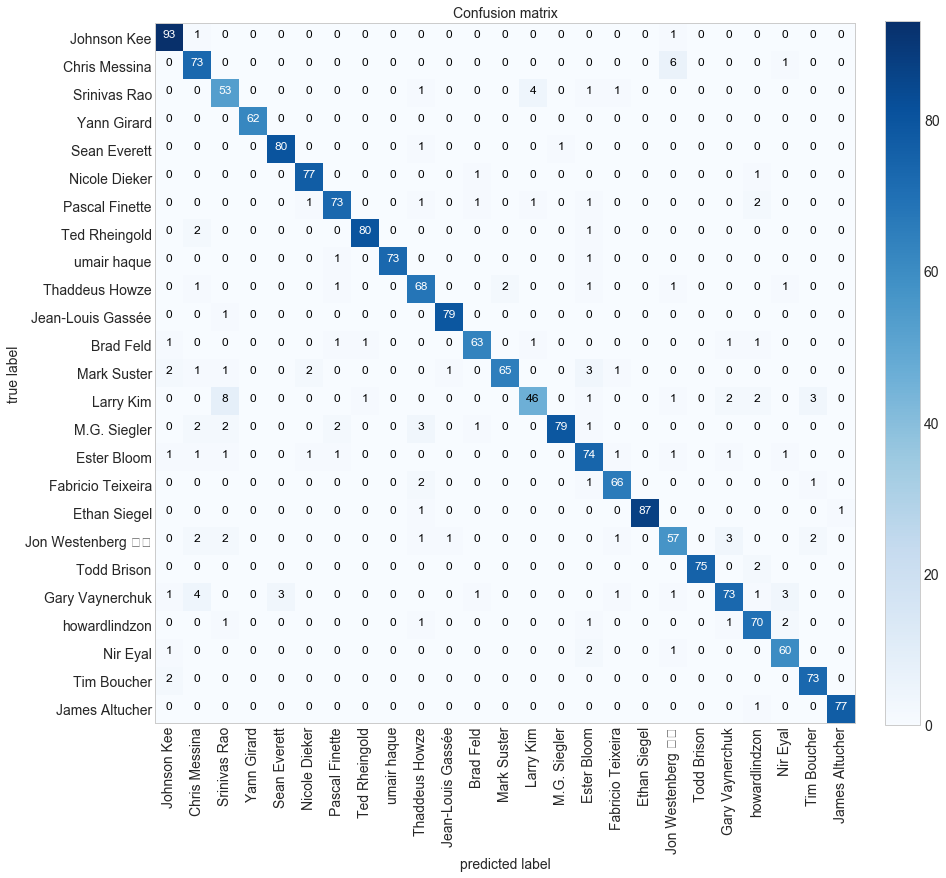

In [24]:
# display confusion matrix

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = [13, 13]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=14)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size=14)
    plt.yticks(tick_marks, classes, size=14)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 size=12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label', size=14)
    plt.xlabel('predicted label', size=14)
    
# Compute confusion matrix
y_test = articles_test[['author']]
for clf in clf_predictions:
    y_predict = clf['labels_predicted']
    if clf['classifier'] == 'logistic regression':
        break
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)
class_names = list(set(labels['author']))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

The confusion matrix allows us to see where exactly the misclassifications happening. We can see that Tim Boucher has been misclassified eight times as howardlindzon. Also, John Westenberg has been misclassified six times as Gary Vaynerchuk. The examples show that misclassification can be concentrated to a few classes. With this confusion matrices can provided valuable cues that are helpful for further fine tuning models.

### Model 4: Bag-of-Words - TFIDF <a name="Model 4 Bag-of-Words - TFIDF"></a>

With all the code for Model 3 developed with reusability in mind, we can now quickly implement another model that utilizes the term frequency–inverse document frequency (TFIDF) approach. In TFIDF, similar to word count, each word represents a feature. Each word is assigned a weight factor that is higher the more often a word occurs in an article. However, at the same time the weight of a word is reduced the more often it occurs across other articles. The idea behind TFIDF is that words that occur more across multiple articles carry less meaning then specialized words that occur within a smaller number of articles.

In the code cell below we only  replace the `CountVectorizer()` vectorizer with the `TfidfVectorizer()` vectorizer.

In [25]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

model_TFIDF = Model_Bag_of_Words('Model 4 Bag-of-Words - TFIDF.pickle')
print('training the model\n')
model_TFIDF.train(articles_train, TfidfVectorizer())
print('number of training articles: {:,}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {:,}'.\
      format(len(model_TFIDF.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_TFIDF.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_TFIDF.score(articles_test)

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
for clf in clf_predictions:
    results = results.append({'group': 'Model 4: Bag-of-Words - TFIDF',
                              'classifier': clf['classifier'],
                              'result': clf['score'],
                              'time': total_time},
                              ignore_index=True)

training the model

number of training articles: 5,756
size of the vocabulary = length of the feature vector: 63,021

scoring the training data:

logistic regression classifier prediction accuracy score : 98.33%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 4.29%

scoring the test data:

logistic regression classifier prediction accuracy score : 91.04%
decision tree classifier prediction accuracy score : 75.09%
SVM classifier prediction accuracy score : 3.13%

total run time: 1.79 min



The performance of the TFIDF model with logistic regression is almost identical to the word count model described in the previous section. The TFIDF of words doesn't help to increase the accuracy in predicting the author. This can be explained by the fact that authors most probably write about specific topics (e.g. entrepreneurship, astrophysics). With this we can expect a high frequency of key topic words within the articles from the same author but less so across all articles in the training set. This in turn means that the IDF part of TFIDF has less impact on the learning. Which then means the TFIDF gets closer to what the word count does.

### Model 5: Bag-of-Words - Reduced Vocabulary <a name="Model 5 Bag-of-Words - Reduced Vocabulary"></a>

During pre-processing model 3 extracts a vocabulary of over 63,000 words from 5,756 training articles. As the vocabulary is used as the feature vector this results in very large vectors. Large feature vectors require more time during the learning phase. In the following code cells we test to what degree a reduced vocabulary impacts our prediction accuracy. We only keep words in the vocabulary that occur at a minimum rate (specified by variable `min_occurrence`).

In [26]:
def get_vocabulary(articles, ngrams):
    data = pre_process_articles(articles)
    vectorizer = CountVectorizer(ngram_range=(ngrams, ngrams))
    data_vectorized = vectorizer.fit_transform(data)
    vocabulary = pd.DataFrame({'token': vectorizer.get_feature_names(),
                               'occurrence': np.asarray(data_vectorized.sum(axis=0)).ravel()})
    vocabulary = vocabulary[['token', 'occurrence']].sort_values('occurrence', ascending=False)
    vocabulary = vocabulary.reset_index().drop(['index'], axis=1)
    return vocabulary

def reduce_vocabulary(vocabulary, min_occurrence):
    vocabulary_reduced = vocabulary[vocabulary['occurrence']>min_occurrence]
    return vocabulary_reduced

def vocabulary_to_dict(vocabulary):
    # new index starting from 0 to total number of tokens
    vocabulary = vocabulary.reset_index().drop(['occurrence'], axis=1)
    # make column token the new index
    vocabulary = vocabulary.set_index('token')
    # transform into dict object
    vocabulary_dict = vocabulary.to_dict()['index']
    return vocabulary_dict

In [27]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

# reduce vocabulary
min_occurrence = 200
ngrams = 1
vocab = get_vocabulary(articles_train, ngrams)
vocab_reduced = reduce_vocabulary(vocab, min_occurrence)
vocab_dict = vocabulary_to_dict(vocab_reduced)

start_time = time.time()

# run the model
model_ReducedVocab = Model_Bag_of_Words('Model 5 Bag-of-Words - Reduced Vocabulary.pickle')
print('training the model\n')
model_ReducedVocab.train(articles_train, CountVectorizer(vocabulary=vocab_dict))
print('number of training articles: {:,}'.format(len(articles_train)))
print('size of the vocabulary = length of the feature vector: {:,}'.\
      format(len(model_ReducedVocab.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_ReducedVocab.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_ReducedVocab.score(articles_test)

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
for clf in clf_predictions:
    results = results.append({'group': 'Model 5: Bag-of-Words - Reduced Vocabulary',
                              'classifier': clf['classifier'],
                              'result': clf['score'],
                              'time': total_time},
                              ignore_index=True)

training the model

number of training articles: 5,756
size of the vocabulary = length of the feature vector: 1,954

scoring the training data:

logistic regression classifier prediction accuracy score : 99.98%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 84.07%

scoring the test data:

logistic regression classifier prediction accuracy score : 88.59%
decision tree classifier prediction accuracy score : 70.09%
SVM classifier prediction accuracy score : 73.16%

total run time: 1.11 min



A number of different thresholds for the minimum occurrence have been tested:

|minimum occurrence|length feature vector|logistic regression accuracy|
|------------------|---------------------|----------------------------|
|      4           |              18,285 |          92.55%            |
|     20           |               7,825 |          92.13%            |
|    100           |               3,102 |          90.78%            |
|    150           |               2,395 |          89.32%            |
|    200           |               1,954 |          88.59%            |

With a moderate threshold of four the logistic regression prediction accuracy remains with 92.55% at the same performance level as model 3. However, the length of the feature vector has been reduced dramatically to 18,285 tokens (compared to 63,021 tokens for model 3). Even with a drastic threshold of 200 the model still performs well above 88% prediction accuracy but with the benefit of a much smaller feature vector. This result shows that the feature vector can be reduced significantly without a large impact on the prediction accuray.

### Model 6: Bag-of-Words - Bigrams <a name="Model 6 Bag-of-Words - Bigrams"></a>

The previous models 3 - 5 only utilized the frequency or count of individual words. These approaches do not try to represent any form of "meaning" in the text. Would our prediction accuracy increase if we find a way to represent relationships between words?

One popular way to represent word relationships in NLP are bigrams (or more generalized n-grams). Bigrams count the occurrence of word pairs. The hypothesis is that certain word combinations used by individual authors in their writings will provide a strong indication of authorship.

The following code cell tests this hypothesis. With `CountVectorizer(ngram_range=(2, 2))` we specify a count vectorizer that vectorizes a given text into bigrams.

In [28]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

# run the model
model_Bigrams = Model_Bag_of_Words('Model 6 Bag-of-Words - Bigrams.pickle')
print('training the model\n')
model_Bigrams.train(articles_train, CountVectorizer(ngram_range=(2, 2)))
print('number of training articles: {:,}'.format(len(articles_train)))
print('size of the bigram vocabulary = length of the feature vector: {:,}'.\
      format(len(model_Bigrams.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_Bigrams.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_Bigrams.score(articles_test)

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
for clf in clf_predictions:
    results = results.append({'group': 'Model 6: Bag-of-Words - Bigrams',
                              'classifier': clf['classifier'],
                              'result': clf['score'],
                              'time': total_time},
                              ignore_index=True)

training the model

number of training articles: 5,756
size of the bigram vocabulary = length of the feature vector: 1,205,446

scoring the training data:

logistic regression classifier prediction accuracy score : 100.00%
decision tree classifier prediction accuracy score : 100.00%
SVM classifier prediction accuracy score : 4.29%

scoring the test data:

logistic regression classifier prediction accuracy score : 87.60%
decision tree classifier prediction accuracy score : 73.48%
SVM classifier prediction accuracy score : 3.13%

total run time: 2.41 min



The results above show one significant disadvantage of the bigram approach: the length of the feature vector literally "explodes" to 1,205,446 features. Given our 5,756 training articles we need to be aware that we are now cursed by dimensionality. In order for a classifier to learn effectively the number of training examples needs to grow with the dimensionality of the feature vector. The Wikipedia article about the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning) mentions an interesting rule of thumb: "there should be at least 5 training examples for each dimension in the representation". Applying this rule to our bigram model would mean to have somewhat over six million training articles. This will be impossible to get for our problem.

Let's see how the prediction accuracy is impacted if we reduce the bigram feature vector.

### Model 7: Bag-of-Words - Reduced Bigrams <a name="Model 7 Bag-of-Words - Reduced Bigrams"></a>

As discussed in the results for the previous model, the use of bigrams during vectorization creates significantly larger feature vectors. This is a problem as it demands a significantly larger volume of training data for the classifier to learn something meaningful. In the following code cell we reduce the length of the feature vector by only keeping bigrams with a minimum number of occurrences.

In [29]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

# reduce vocabulary
min_occurrence = 7
ngrams = 2
vocabulary = get_vocabulary(articles_train, ngrams)
vocabulary = reduce_vocabulary(vocabulary, min_occurrence)
vocabulary_dict = vocabulary_to_dict(vocabulary)

# run the model
model_Bigrams = Model_Bag_of_Words('Model 7 Bag-of-Words - Reduced Bigrams.pickle')
print('training the model\n')
model_Bigrams.train(articles_train, CountVectorizer(vocabulary=vocabulary_dict,
                                                    ngram_range=(2, 2)))
print('number of training articles: {:,}'.format(len(articles_train)))
print('size of the bigram vocabulary = length of the feature vector: {:,}'.\
      format(len(model_Bigrams.vectorizer.vocabulary_)))
print('\nscoring the training data:\n')
model_Bigrams.score(articles_train)
print('\nscoring the test data:\n')
clf_predictions = model_Bigrams.score(articles_test)

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
for clf in clf_predictions:
    results = results.append({'group': 'Model 7: Bag-of-Words - Reduced Bigrams',
                              'classifier': clf['classifier'],
                              'result': clf['score'],
                              'time': total_time},
                              ignore_index=True)

training the model

number of training articles: 5,756
size of the bigram vocabulary = length of the feature vector: 31,169

scoring the training data:

logistic regression classifier prediction accuracy score : 99.81%
decision tree classifier prediction accuracy score : 99.90%
SVM classifier prediction accuracy score : 11.71%

scoring the test data:

logistic regression classifier prediction accuracy score : 86.71%
decision tree classifier prediction accuracy score : 72.75%
SVM classifier prediction accuracy score : 9.69%

total run time: 1.00 min



A number of different thresholds for the minimum occurrence have been tested:

|minimum occurrence|length feature vector|logistic regression accuracy|
|------------------|---------------------|----------------------------|
|      4           |              65,839 |          87.81%            |
|      7           |              31,169 |          86.71%            |
|     10           |              19,258 |          86.35%            |
|     20           |               7,174 |          84.37%            |
|    100           |                 657 |          70.24%            |

With a threshold of four we can see that the prediction accuracy of the logistic regression classifier increases slightly compared to model 6. A possible explanantion for this behaviour is offered by the Hughes phenomenon. This phenomenon states that ["the predictive power of a classifier or regressor first increases as number of dimensions/features used is increased but then decreases"](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning). It appears that we are far on the side of decreased performance. By reducing the lenght of the feature vector we have increased the power of the classifier.

### Model 8: Learn Word Embeddings & CNN <a name="Model 8 Learn Word Embeddings & CNN"></a>

Another approach to numerically represent meaning in text is offered by using word embeddings. Word embedding algorithms such as Word2Vec and GloVe aim to find similar representations for words with similar meanings. Individual words are represented by vectors with tens or several hundred dimensions. These vectors are learned by processing a large amount of text through a neural network. During learning, the algorithm learns the embedding either by predicting the current word based on its context or by predicting the surrounding words given a current word. The result of the embeddings learning phase is a set of vectors where words with similar meanings have similar vectors. Essentially "similarness" is represented by the distance between word vectors. The vector representations of words with similar meanings have shorter distances between them.

In recent years word embedding approaches have been one of the key breakthroughs in natural language processing.

Based on this promising outlook we will test the word embeddings approach on our problem in the following two models. Model 8 will learn word embeddings as part of the convolutional neural network (CNN). In model 9 we will use pre-trained word embeddings.

A very helpful resource for this topic was the book "Deep Learning for Natural Language Processing, Develop Deep Learning Models for Natural Language in Python" from Jason Brownlee. From this book  (page 163) the CNN used in this model has been taken. The model has been modified to a multiclass classifier (original model was a binary classifier for sentiment analysis).

A key learning from implementing this model: The `one_hot` function from the `keras.preprocessing.text` library was originally used to convert the words in articles to integer values. This was done as preparation to train the CNN. However, `one_hot` does not encode collision free. During testing it has been found that against a text corpus with 54,619 unique words `one_hot` caused 22,793 collisions. Meaning 22,793 integers were not uniquely mapped to single words. It is believed that this high proportion of collisions significantly distorts the learning of the embedding CNN. To resolve this issue function `learn_vocabulary` has been implemented (see below).

In [30]:
def pre_process_article(article):
    """ Some preprocessing and cleaning tasks to be applied to the raw input text
    of an article.
    """
    stop_words = set(stopwords.words('english'))
    words = tokenize_words(article)['words']
    # remove punctuation from word list
    re_punc = re.compile('[%s]' % re.escape(string.punctuation + '—'))
    words = [re_punc.sub('', w) for w in words]
    words = [word for word in words if not word=='']
    # remove words that are not completely alphabetic
    words = [word for word in words if word.isalpha()]
    # transform to lowercase
    words = [word.lower() for word in words]
    # remove stop words
    words = [word for word in words if not word.lower() in stop_words]
    # remove short words
    words = [word for word in words if len(word)>1]
    processed_article = words
    return processed_article

def learn_vocabulary(articles):
    """ Learn the vocabulary for a given text corpus.
    
    The result is a dictionary that translates each unique word (the keys) into
    unique integer values. This vocabulary can be be used to encode a text into
    a series of integers. This is an activity required to prepare text for use
    with word embeddings such as GloVe and Word2Vec.
    """
    vocab = {'': 0}
    curr_int = 1
    for article in articles:
        for word in article:
            if not word in vocab.keys():
                vocab[word] = curr_int
                curr_int += 1
    return vocab

def encode_articles(pre_processed_articles, vocabulary):
    """ Encode the words in a list of articles into integers.
    """
    return [encode_article(article, vocabulary) for article in pre_processed_articles]

def encode_article(article, vocabulary):
    """ Encode a single word into its integer index.
    The word-to-integer mapping needs to be given with the vocabulary dictionary.
    """    
    return [vocabulary.get(word, 0) for word in article]

def prep_training_data(articles_train):
    """ Prepare the articles in the training data set for use with
    word embeddings and CNN.
    """
    # encode the author names to integers
    author_to_int = {a: i for i, a in enumerate(set(articles_train['author']))}
    authors_encoded = [author_to_int[author] for author in list(articles_train['author'])]
    # pre-process the articles
    pre_processed_articles = [pre_process_article(article['body']) for index, article in articles_train.iterrows()]
    # encode words to integers
    vocabulary = learn_vocabulary(pre_processed_articles)
    vocab_size = len(vocabulary)
    encoded_articles = encode_articles(pre_processed_articles, vocabulary)
    # get length of longest article
    article_lengths = pd.DataFrame([len(article) for article in encoded_articles],
                                   columns=['length'])
    max_length = article_lengths['length'].max()
    # pad article lenghts to longest article
    padded_articles = pad_sequences(encoded_articles, maxlen=max_length, padding='post')
    return padded_articles, author_to_int, authors_encoded, vocabulary, vocab_size, max_length

def prep_test_data(articles_test, vocabulary, max_length, author_to_int):
    """ Prepare the articles in the test data set for use with
    word embeddings and CNN.
    """
    # pre-process the articles
    pre_processed_articles = [pre_process_article(article['body']) for index, article in articles_test.iterrows()]
    # encode words to integers
    encoded_articles = encode_articles(pre_processed_articles, vocabulary)
    # pad article lenghts to longest article 
    padded_articles = pad_sequences(encoded_articles, maxlen=max_length, padding='post')
    # encode the author names to integers
    authors_encoded = [author_to_int[author] for author in list(articles_test['author'])]
    return padded_articles, authors_encoded

def build_CNN(embedding):
    """ The CNN is based on the CNN model with embedding layer shown in 
     "Deep Learning for Natural Language Processing, Develop Deep Learning Models for
     Natural Language in Python" by Jason Brownlee, page 163. The model has been modified
     to a multiclass classifier (original model was a binary classifier for sentiment
     analysis).
    """
    model = Sequential()
    model.add(embedding)
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [31]:
class Model_Embeddings_CNN:

    def __init__(self):
        pass
        
    def train(self, padded_articles, authors_encoded, model, file):
        self.model = model
        # fit CNN model and save learned model to file
        self.model.fit(padded_articles, authors_encoded, epochs=10, verbose=1)
        self.model.save(file)
        
    def predict(self, articles, vocabulary, author_to_int, max_length):
        # pre-process the articles
        pre_processed_articles = [pre_process_article(article) for article in articles]
        # encode words to integers
        encoded_articles = encode_articles(pre_processed_articles, vocabulary)
        # pad article lenghts to longest article 
        padded_articles = pad_sequences(encoded_articles, maxlen=max_length, padding='post')
        # make predictions
        probabilities = self.model.predict(padded_articles, verbose=1)
        predictions = pd.DataFrame({'author': list(author_to_int.keys()),
                                    'probability': probabilities[0]})
        index = predictions['probability'].idxmax()
        author = predictions.loc[index]['author']
        probability = predictions.loc[index]['probability']
        return author, probability
        
    def score(self, padded_articles, authors_encoded):
        # score the model
        loss, accuracy = self.model.evaluate(padded_articles, authors_encoded, verbose=1)
        return loss, accuracy

In [35]:
max_length

12580

In [32]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

# prepare the training data
padded_articles, author_to_int, authors_encoded, vocabulary, vocab_size, max_length = prep_training_data(articles_train)

# build and train the CNN model
embedding = Embedding(vocab_size, 100, input_length=max_length)
model = build_CNN(embedding)
model.summary()
model_Embeddings_CNN = Model_Embeddings_CNN()
file = 'Model 8 Learn Word Embeddings & CNN.h5'
print('training the model\n')
model_Embeddings_CNN.train(padded_articles, authors_encoded, model, file)

# assess accuracy of the training data set
print('\nscoring the training data:\n')
loss, accuracy = model_Embeddings_CNN.score(padded_articles, authors_encoded)
print('accuracy score : {:.2f}%'.format(accuracy*100))

# prepare the test data
padded_articles, authors_encoded = prep_test_data(articles_test, vocabulary, max_length, author_to_int)

# assess accuracy of the test data set
print('\nscoring the test data:\n')
loss, accuracy = model_Embeddings_CNN.score(padded_articles, authors_encoded)
print('accuracy score : {:.2f}%'.format(accuracy*100))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 8: Learn Word Embeddings & CNN',
                          'classifier': 'CNN',
                          'result': accuracy,
                          'time': total_time},
                          ignore_index=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12580, 100)        7629000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12573, 32)         25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6286, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 201152)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2011530   
_________________________________________________________________
dense_2 (Dense)              (None, 25)                275       
Total params: 9,666,437
Trainable params: 9,666,437
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

When predicting authors based on word embeddings learned from scratch we achieve a prediction accuracy on the test data of 13.18% (please note, results vary significantly with different runs of this notebook). This is a very low prediction accuray. This can be explained by the fact that the word embeddings were learned from only 5,756 articles (around 3.5 million words/tokens). Word embeddings are algorithms that require large amount of training data to properly learn relationships between words. Available pre-trained word embeddings were trained on significantly larger text corpora. For example the GloVe word embeddings file [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) contains 6 billion tokens and a vocabulary of 400,000 words and was trainind on the Wikipedia corpus.

Let's use this model to make a prediction with the raw text as input. The code cell below demonstrates the simple interface to the model.

In [ ]:
# make a prediction
text = articles.iloc[3]['body']
author = articles.iloc[3]['author']
print('\nI guess this text ...\n')
print(text)
author, probability = model_Embeddings_CNN.predict([text], vocabulary, author_to_int, max_length)
print('\n... was written by {} with {:.2f}% confidence\n'.format(author, probability*100))
print('The actual author is {}'.format(author))

### Model 9: GloVe Word Embeddings & CNN <a name="Model 9 GloVe Word Embeddings & CNN"></a>

In our last model we will utilize pre-trained word embeddings from the [GloVe algorithm](https://nlp.stanford.edu/projects/glove/). This is done based on the hypothesis that the GloVe word embeddings will provide much more accurate representations of word relationships than what we can train with our limited training data set. 


In [ ]:
def assign_GloVe_weights(vocabulary):
    """ Assign GloVe word vectors to a vocabulary of words
    """
    vocab_size = len(vocabulary)
    embeddings_index = load_trained_GloVe()
    embedding_matrix = zeros((vocab_size, 300))
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def load_trained_GloVe():
    """ Load the GloVe word vectors from file. In case the word vector file
    doesn't exist, download it.
    """
    # check if pre-trained word vectors file is available
    file = 'glove.6B.zip'
    if not os.path.isfile(file):
        url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        print('downloading pre-trained word vectors, url: {}'.format(url))
        wget.download(url, file)
    # load pre-trained GloVe embedding from ZIP file
    embeddings_index = {}
    with zipfile.ZipFile('glove.6B.zip', 'r') as zf:
        with zf.open('glove.6B.300d.txt', 'r') as f:
            for line in f:
                values = line.split()
                word = values[0].decode("utf-8")
                coefs = asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    return embeddings_index

In [ ]:
# split training and test data
articles_train, articles_test = train_test_split(articles, test_size=0.25, random_state=23)

start_time = time.time()

# prepare the training data
padded_articles, author_to_int, authors_encoded, vocabulary, vocab_size, max_length = prep_training_data(articles_train)

# assign GloVe weights to words
embedding_matrix = assign_GloVe_weights(vocabulary)

# build and train the CNN model
# TODO: test with trainable=True
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix],
                      input_length=max_length, trainable=False)
model = build_CNN(embedding)
model.summary()
model_GloVe = Model_Embeddings_CNN()
file = 'Model 9 GloVe Word Embeddings & CNN.h5'
print('training the model\n')
model_GloVe.train(padded_articles, authors_encoded, model, file)

# assess accuracy of the training data set
print('\nscoring the training data:\n')
loss, accuracy = model_GloVe.score(padded_articles, authors_encoded)
print('accuracy score : {:.2f}%'.format(accuracy*100))

# prepare the test data
padded_articles, authors_encoded = prep_test_data(articles_test, vocabulary, max_length, author_to_int)

# assess accuracy of the test data set
print('\nscoring the test data:\n')
loss, accuracy = model_GloVe.score(padded_articles, authors_encoded)
print('accuracy score : {:.2f}%'.format(accuracy*100))

total_time = time.time() - start_time
print('\ntotal run time: {:.2f} min\n'.format(total_time/60))

# save results
results = results.append({'group': 'Model 9: GloVe Word Embeddings & CNN',
                          'classifier': 'CNN',
                          'result': accuracy,
                          'time': total_time},
                          ignore_index=True)

Compared to a self trainined embeddings layer we achieve a significantly better prediction accuracy of 55.24% by using the pre-trained GloVe word vectors (prediction rate will vary with different runs of the notebook). However, we are still far-off from the the prediction performance of model 3 with 92.55% (count vectorizer and logistic regression classifier).

It appears that word embeddings are not the right approach for our problem. Word embedding algorithms put emphasis on representation of meaning in text. The approach might be more useful if we want to classify articles by their content (e.g. astronomy, programming, finance, etc.).

---
## Conclusion <a name="Conclusion"></a>

The chart below summarizes the test data prediction accuracy of the various models we have discussed throughout this notebook.

In [ ]:
def percentage_to_bar(rects):
    for rect in rects:
        height = rect.get_height()
        width = rect.get_width()
        if not np.isnan(width):
            ax.text(rect.get_x() + width + 0.01, rect.get_y() + 0.1,
                        '{:.2f}%'.format(width*100), fontsize=12,
                        ha='left', va='center')

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = [13, 13]

# group by model
#results_percent = results.copy()
#results_percent['result'] = results['result'] * 100
result_groups = results.pivot(index='group', columns='classifier', values='result')
# within each group we will show each classifier
classifiers = ['CNN',
               'random selection',
               'grid search decision tree',
               'decision tree',
               'SVM',
               'logistic regression']

# set some general plotting parameters
pos = list(range(len(list(result_groups.index))))
height = 0.2
fig, ax = plt.subplots(figsize=(10,12))
# get some nice looking color scheme from https://coolors.co/162833-e2b161-d5573b-faffef-c7c9c8
color_cycler = itertools.cycle(['#706c61', '#9e9889', '#c4b899', '#eddcaf', '#f4d681', '#f4ba1a'])

# generate the bar charts
x_values = result_groups['CNN']
rects = plt.barh([p + 2 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

x_values = result_groups['random selection']
rects = plt.barh([p + 2 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

x_values = result_groups['grid search decision tree']
rects = plt.barh([p + 2 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

x_values = result_groups['decision tree']
rects = plt.barh([p + 1 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

x_values = result_groups['SVM']
rects = plt.barh([p + 2 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

x_values = result_groups['logistic regression']
rects = plt.barh([p + 3 * height for p in pos], x_values, height=height, color=next(color_cycler))
percentage_to_bar(rects)

# set the chart's title
ax.set_title('Prediction Accuracy', size=14)

# configure the x axis
ax.set_xlabel('accuracy predicting test data', size=14)
ax.set_xlim([0,1.08])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Set the labels for the y ticks
model_names = list(result_groups.index)
ax.set_yticklabels(list(model_names), size=14)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 

# set the position of the y ticks
ax.set_yticks([p + 0.5 for p in pos])

# Adding the legend and showing the plot
plt.legend(classifiers, loc='upper right', prop={'size': 12})
plt.grid()
plt.show()

It is interesting to see that the good old logistic regression classifier in model 3 has achieved a prediction accuracy of 92.55%. With that it has significantly outperformed all other classification approaches. This is a good reminder that, even with todays state of the art algorithms, it's always worth to look into simpler algorithms.

The reason why the more sophisticated models 8 & 9 with word embeddings and CNNs didn't perform better, is probably because of the small size of training data available. Word embeddings require large volumes of training data to pick up the relationship between individual words. For the problem addressed in this project, predicting the authorship of a given text, the amount of training data will always be very limited. As shown in section [Exploring the Data Set](#Exploring the Data Set) the most active authors have produced a few hundred articles. Only six have produced 1,000 and more articles. If an application needs to be developed that needs to classify articles into topic categories (sport, gardening , science, ....) then the amount of training data will definitely be much higher as much more authors will write about the same topic. This would make the word embeddings approach worthwhile to revisit. 

It is worthwhile to note that model 2 achieved a prediction accuracy above 30%. This model was build only on features reflecting the number of words in articles, paragraphs and sentences. The model does not take anything of the article content into account. In future improvements this model might be used as part of an ensemble learner to improve the prediction accuracy.

Throughout the development of this notebook some effort has been put into refactoring the code with re-usability in mind. Jupyter notebooks are a great tool for testing approaches and algorithms. Once a promising model has been identified, it is expected that a notebook like this will be handed over to an implementation developer who will transform the code into something that can be shipped to production. Models 3 - 9 have been implemented as Python classes with a consistent interface providing `train`, `predict` and `score` methods. Pre-processing activities have been "packaged" into separate functions which supports reuse and, hopefully, code readability. It is believed that instilling a "production usable" mindset in machine learning engineers will benefit the quick transition of new ideas into usable applications. The last section in this notebook demonstrates the simplicity with which the successful model 3 can be used in a simple application.

An important learning from this project is to keep an eye on testing the different stages of the machine learning pipeline. For all of the models discussed above the raw text from the articles had to be transformed in several stages in order to be used with a classifier or a neural network. The initial text cleaning tasks (removal of punctuation and stop words, stemming, transform all words to lowercase) are fairly straightforward and can be validated by a simple visual inspection of a few samples. It gets a bit more tricky when text is transformed into numbers such as word counts or, even more so, integers that act as pointers to word vectors. Are the numbers I now see are integer indexes or still the word counts from the model I tried earlier? Am I sure that each word/token has now been encoded with its unique integer value? The challenge with machine learning implementation is that bugs not necessarily manifest themselves in hard stops of the code. How do you know whether the reported prediction accuracy of X% is because of the limits of the model or because of a bug in your vectorization code? To address this it is worthwhile for machine learning engineers to be mindful about testability of the different stages of a machine learning system.

In [ ]:
Notebook_total_time = time.time() - Notebook_start_time
print('total run time for this Notebook: {:.1f} hours'.format(Notebook_total_time/3600))

---
## Let's have some fun: the WhoWroteThis app <a name="WhoWroteThis app"></a>

Now that we have a working prediction model let's build a little app that makes use of the model we have trained and tested.

Run the cell below and follow the instructions shown in the output area.

In [28]:
def on_button_clicked(button):
    test_article = pd.DataFrame([text_input_box.value], columns=['body'])
    predictions = model_WordCount.predict(test_article, 'logistic regression')
    index = predictions['probability'].idxmax()
    author = predictions.loc[index]['author']
    probability = predictions.loc[index]['probability']*100
    print('I\'m {:.0f} percent certain that this was written by... {}.'.format(probability, author))

text_input_box = widgets.Textarea(
    value='',
    placeholder='Please paste an article here.',
    disabled=False,
    layout=Layout(width='700px', height='300px')
)
button = widgets.Button(
    description='Who wrote this?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

print('From the list of Medium authors below pick one. Select an article and copy the')
print('text in the text box below. Press the "Who wrote this?" button and see whether')
print('the right author is predicted.\n')
with open('Medium_authors_25.txt','r') as f:
    author_urls = f.read()
print(author_urls)

button.on_click(on_button_clicked)
display(text_input_box, button)

From the list of Medium authors below pick one. Select an article and copy the
text in the text box below. Press the "Who wrote this?" button and see whether
the right author is predicted.

https://medium.com/@tedr/latest
https://medium.com/@garyvee/latest
https://medium.com/@NicoleDieker/latest
https://medium.com/@fabriciot/latest
https://medium.com/@esterbloom/latest
https://medium.com/@startswithabang/latest
https://medium.com/@girard_yann/latest
https://medium.com/@pfinette/latest
https://medium.com/@jonwestenberg/latest
https://medium.com/@chrismessina/latest
https://medium.com/@msuster/latest
https://medium.com/@howardlindzon/latest
https://medium.com/@umairh/latest
https://medium.com/@jaltucher/latest
https://medium.com/@JohnsonKee/latest
https://medium.com/@larrykim/latest
https://medium.com/@seanmeverett/latest
https://medium.com/@timboucher/latest
https://medium.com/@mgsiegler/latest
https://medium.com/@nireyal/latest
https://medium.com/@skooloflife/latest
https://medium.com/

A Jupyter Widget

A Jupyter Widget

---
## Sources <a name="Sources"></a>

The following sources served as inspiration for this project and provided valuable guidance for implementing NLP systems. 

[1] [Famous Authors and Their Writing Styles](https://www.craftyourcontent.com/famous-authors-writing-styles/)

[2] ["Who’s At The Keyboard? Authorship Attribution in Digital Evidence Investigations"](www.utica.edu/academic/institutes/ecii/publications/articles/B49F9C4A-0362-765C-6A235CB8ABDFACFF.pdf)

[3] ["How a Computer Program Helped Show J.K. Rowling write A Cuckoo’s Calling"](https://www.scientificamerican.com/article/how-a-computer-program-helped-show-jk-rowling-write-a-cuckoos-calling/)

[4] [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)

[5] [scikit learn documentation: confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

[6] [Deep Learning for Natural Language Processing, Develop Deep Learning Models for your Natural Language Problems](https://machinelearningmastery.com/deep-learning-for-nlp/)

[7] [Deep Learning for NLP Best Practices](http://ruder.io/deep-learning-nlp-best-practices/index.html#wordembeddings)

[8] [Multi-Class Classification Tutorial with the Keras Deep Learning Library](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)